In [1]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [2]:
import copy
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False
import numpy as np

In [3]:
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
gauss = GaussianEllipse()

# Set up the model

## Simulate the main deflector

Mass distribution given by a singular isothermal ellipsoid with a shear, then light with a sersic ellipse profile

In [4]:
from lenstronomy.LensModel.lens_model import LensModel

lens_model_list = ['SIE', 'SHEAR']

kwargs_spemd = {'theta_E': 1.7, 'e1': 0.07, 'e2': -0.03, 'center_x': 0.05, 'center_y': -0.25}
kwargs_shear = {'gamma1': 0.1, 'gamma2': -0.05}

kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list)

from lenstronomy.LightModel.light_model import LightModel

lens_light_model_list = ['SERSIC_ELLIPSE']

kwargs_sersic_lens = {'amp': 10, 'R_sersic': 0.6, 'n_sersic': 2, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.05, 'center_y': 0}

kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(lens_light_model_list)

## Simulate the source

Light with a sersic ellipse profile

In [5]:
source_model_list = ['SERSIC_ELLIPSE']

kwargs_sersic = {'amp': 10, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0}

kwargs_source = [kwargs_sersic]
source_model_class = LightModel(source_model_list)

We don't need this yet, but we'll need it for the telescope images later (`SimulationAPI`)

In [6]:
kwargs_model = {'lens_model_list': lens_model_list,
                'lens_light_model_list': lens_light_model_list,
                'source_light_model_list': source_model_list}

# Image the model

## Set up the coordinate-to-pixel transformation

In [7]:
from lenstronomy.Data.pixel_grid import PixelGrid

num_pix = 100
delta_pix = 0.05  # size of pixel in angular coordinates
ra_at_xy_0, dec_at_xy_0 = -2.5, -2.5 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * delta_pix  # linear translation matrix of a shift in pixel in a shift in coordinates

kwargs_pixel = {'nx': num_pix, 'ny': num_pix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle}

pixel_grid = PixelGrid(**kwargs_pixel)

## Set up the PSF

In [8]:
from lenstronomy.Data.psf import PSF

# kwargs_psf = {'psf_type': 'GAUSSIAN',
#               'fwhm': 0.1,
#               'pixel_size': delta_pix}

kwargs_psf = {'psf_type': 'NONE'}

psf_class = PSF(**kwargs_psf)

## Combine

In [9]:
from lenstronomy.ImSim.image_model import ImageModel

kwargs_numerics = {'supersampling_factor': 2,
                   'supersampling_convolution': False}

imageModel = ImageModel(data_class=pixel_grid,
                        psf_class=psf_class,
                        lens_model_class=lens_model_class,
                        source_model_class=source_model_class,
                        lens_light_model_class=lens_light_model_class,
                        kwargs_numerics=kwargs_numerics)

## Look at the image

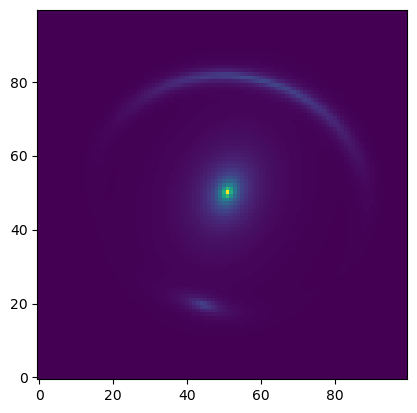

In [10]:
image = imageModel.image(kwargs_lens=kwargs_lens,
                         kwargs_source=kwargs_source,
                         kwargs_lens_light=kwargs_lens_light)

plt.imshow(image, origin='lower')
plt.show()

# Observe with HST

HST's pixel scale: 0.08


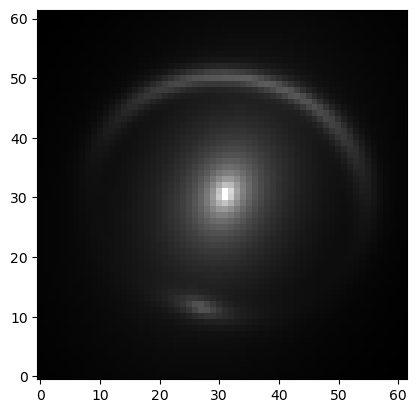

In [11]:
from lenstronomy.SimulationAPI.ObservationConfig.HST import HST

HST_wfc3_f160w = HST(band='WFC3_F160W', psf_type='GAUSSIAN', coadd_years=None)

kwargs_wfc3_f160w = HST_wfc3_f160w.kwargs_single_band()

hst_pixel_scale = HST_wfc3_f160w.kwargs_single_band().get('pixel_scale')
print('HST\'s pixel scale: ' + str(hst_pixel_scale))

hst_num_pix = int(5 / hst_pixel_scale)

sim_wfc3_f160w = SimAPI(numpix=hst_num_pix, kwargs_single_band=kwargs_wfc3_f160w, kwargs_model=kwargs_model)

imSim_kwargs_wfc3_f160w = sim_wfc3_f160w.image_model_class(kwargs_numerics)

# set magnitudes
lens_light_mag_wfc3_f160w = 14.
source_mag_wfc3_f160w = 19.

# lens light (`kwargs_sersic_lens`)
kwargs_lens_light_mag_wfc3_f160w = [copy.deepcopy(kwargs_sersic_lens)]
del kwargs_lens_light_mag_wfc3_f160w[0]['amp']
kwargs_lens_light_mag_wfc3_f160w[0]['magnitude'] = lens_light_mag_wfc3_f160w

# source light (`kwargs_sersic`)
kwargs_source_mag_wfc3_f160w = [copy.deepcopy(kwargs_sersic)]
del kwargs_source_mag_wfc3_f160w[0]['amp']
kwargs_source_mag_wfc3_f160w[0]['magnitude'] = source_mag_wfc3_f160w

kwargs_lens_light_wfc3_f160w, kwargs_source_wfc3_f160w, _ = sim_wfc3_f160w.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_wfc3_f160w, kwargs_source_mag=kwargs_source_mag_wfc3_f160w)

image_wfc3_f160w = imSim_kwargs_wfc3_f160w.image(kwargs_lens=kwargs_lens, kwargs_lens_light=kwargs_lens_light_wfc3_f160w, kwargs_source=kwargs_source_wfc3_f160w)

# add noise
image_wfc3_f160w += sim_wfc3_f160w.noise_for_model(model=image_wfc3_f160w)

hst_image = np.zeros((image_wfc3_f160w.shape[0], image_wfc3_f160w.shape[1], 1), dtype=float)
hst_image[:,:,0] = plot_util.sqrt(image_wfc3_f160w, scale_min=0, scale_max=10000)

plt.imshow(hst_image, aspect='equal', origin='lower', cmap='gray')
plt.show()

# Observe with Roman

Use `lenstronomy` defaults

In [12]:
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman

# Roman_F062 = Roman(band='F062', psf_type='GAUSSIAN', survey_mode='wide_area')
# Roman_Z087 = Roman(band='F087', psf_type='GAUSSIAN', survey_mode='microlensing')
Roman_Y106 = Roman(band='F106', psf_type='GAUSSIAN', survey_mode='wide_area')
# Roman_J129 = Roman(band='F129', psf_type='GAUSSIAN', survey_mode='wide_area')
# Roman_H158 = Roman(band='F158', psf_type='GAUSSIAN', survey_mode='wide_area')
# Roman_F184 = Roman(band='F184', psf_type='GAUSSIAN', survey_mode='wide_area')
# Roman_W146 = Roman(band='F146', psf_type='GAUSSIAN', survey_mode='microlensing')

# kwargs_f062 = Roman_F062.kwargs_single_band()
kwargs_f106 = Roman_Y106.kwargs_single_band()
# kwargs_f129 = Roman_J129.kwargs_single_band()
# kwargs_f158 = Roman_H158.kwargs_single_band()
# kwargs_f184 = Roman_F184.kwargs_single_band()

Make an adjustment for the scale of the image based on the telescope's pixel scale. The model image is 5"x5".

In [13]:
roman_pixel_scale = Roman_Y106.kwargs_single_band().get('pixel_scale')
print('Roman\'s pixel scale: ' + str(roman_pixel_scale))

roman_num_pix = int(5 / roman_pixel_scale)

Roman's pixel scale: 0.11


Build `SimAPI` objects

In [14]:
# sim_f062 = SimAPI(numpix=roman_num_pix, kwargs_single_band=kwargs_f062, kwargs_model=kwargs_model)
sim_f106 = SimAPI(numpix=roman_num_pix, kwargs_single_band=kwargs_f106, kwargs_model=kwargs_model)
# sim_f129 = SimAPI(numpix=roman_num_pix, kwargs_single_band=kwargs_f129, kwargs_model=kwargs_model)
# sim_f158 = SimAPI(numpix=roman_num_pix, kwargs_single_band=kwargs_f158, kwargs_model=kwargs_model)
# sim_f184 = SimAPI(numpix=roman_num_pix, kwargs_single_band=kwargs_f184, kwargs_model=kwargs_model)

# imSim_kwargs_f062 = sim_f062.image_model_class(kwargs_numerics)
imSim_kwargs_f106 = sim_f106.image_model_class(kwargs_numerics)
# imSim_kwargs_f129 = sim_f129.image_model_class(kwargs_numerics)
# imSim_kwargs_f158 = sim_f158.image_model_class(kwargs_numerics)
# imSim_kwargs_f184 = sim_f184.image_model_class(kwargs_numerics)

## Set up magnitudes of the lens and source light

In [15]:
# set lens light magnitudes
# lens_light_mag_f062 = 14.
lens_light_mag_f106 = 22.5
# lens_light_mag_f129 = 15.
# lens_light_mag_f158 = 16.
# lens_light_mag_f184 = 16.

# set source light magnitudes
# source_mag_f062 = 18.
source_mag_f106 = 26.5
# source_mag_f129 = 17.
# source_mag_f158 = 16.
# source_mag_f184 = 16.

In [16]:
# lens light (`kwargs_sersic_lens`)
# kwargs_lens_light_mag_f062 = [copy.deepcopy(kwargs_sersic_lens)]
# del kwargs_lens_light_mag_f062[0]['amp']
# kwargs_lens_light_mag_f062[0]['magnitude'] = lens_light_mag_f062

kwargs_lens_light_mag_f106 = [copy.deepcopy(kwargs_sersic_lens)]
del kwargs_lens_light_mag_f106[0]['amp']
kwargs_lens_light_mag_f106[0]['magnitude'] = lens_light_mag_f106

# kwargs_lens_light_mag_f129 = [copy.deepcopy(kwargs_sersic_lens)]
# del kwargs_lens_light_mag_f129[0]['amp']
# kwargs_lens_light_mag_f129[0]['magnitude'] = lens_light_mag_f129

# kwargs_lens_light_mag_f158 = [copy.deepcopy(kwargs_sersic_lens)]
# del kwargs_lens_light_mag_f158[0]['amp']
# kwargs_lens_light_mag_f158[0]['magnitude'] = lens_light_mag_f158

# kwargs_lens_light_mag_f184 = [copy.deepcopy(kwargs_sersic_lens)]
# del kwargs_lens_light_mag_f184[0]['amp']
# kwargs_lens_light_mag_f184[0]['magnitude'] = lens_light_mag_f184

# source light (`kwargs_sersic`)
# kwargs_source_mag_f062 = [copy.deepcopy(kwargs_sersic)]
# del kwargs_source_mag_f062[0]['amp']
# kwargs_source_mag_f062[0]['magnitude'] = source_mag_f062

kwargs_source_mag_f106 = [copy.deepcopy(kwargs_sersic)]
del kwargs_source_mag_f106[0]['amp']
kwargs_source_mag_f106[0]['magnitude'] = source_mag_f106

# kwargs_source_mag_f129 = [copy.deepcopy(kwargs_sersic)]
# del kwargs_source_mag_f129[0]['amp']
# kwargs_source_mag_f129[0]['magnitude'] = source_mag_f129

# kwargs_source_mag_f158 = [copy.deepcopy(kwargs_sersic)]
# del kwargs_source_mag_f158[0]['amp']
# kwargs_source_mag_f158[0]['magnitude'] = source_mag_f158

# kwargs_source_mag_f184 = [copy.deepcopy(kwargs_sersic)]
# del kwargs_source_mag_f184[0]['amp']
# kwargs_source_mag_f184[0]['magnitude'] = source_mag_f184

Turn magnitude kwargs into amplitude kwargs

In [17]:
# kwargs_lens_light_f062, kwargs_source_f062, _ = sim_f062.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_f062, kwargs_source_mag=kwargs_source_mag_f062)
kwargs_lens_light_f106, kwargs_source_f106, _ = sim_f106.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_f106, kwargs_source_mag=kwargs_source_mag_f106)
# kwargs_lens_light_f129, kwargs_source_f129, _ = sim_f129.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_f129, kwargs_source_mag=kwargs_source_mag_f129)
# kwargs_lens_light_f158, kwargs_source_f158, _ = sim_f158.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_f158, kwargs_source_mag=kwargs_source_mag_f158)
# kwargs_lens_light_f184, kwargs_source_f184, _ = sim_f184.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_f184, kwargs_source_mag=kwargs_source_mag_f184)

## Simulate Roman image

In [18]:
# image_f062 = imSim_kwargs_f062.image(kwargs_lens=kwargs_lens, kwargs_lens_light=kwargs_lens_light_f062, kwargs_source=kwargs_source_f062)
image_f106 = imSim_kwargs_f106.image(kwargs_lens=kwargs_lens, kwargs_lens_light=kwargs_lens_light_f106, kwargs_source=kwargs_source_f106)
# image_f129 = imSim_kwargs_f129.image(kwargs_lens=kwargs_lens, kwargs_lens_light=kwargs_lens_light_f129, kwargs_source=kwargs_source_f129)
# image_f158 = imSim_kwargs_f158.image(kwargs_lens=kwargs_lens, kwargs_lens_light=kwargs_lens_light_f158, kwargs_source=kwargs_source_f158)
# image_f/184 = imSim_kwargs_f184.image(kwargs_lens=kwargs_lens, kwargs_lens_light=kwargs_lens_light_f184, kwargs_source=kwargs_source_f184)

# add noise
# image_f062 += sim_f062.noise_for_model(model=image_f062)
image_f106 += sim_f106.noise_for_model(model=image_f106)
# image_f129 += sim_f129.noise_for_model(model=image_f129)
# image_f158 += sim_f158.noise_for_model(model=image_f158)
# image_f184 += sim_f184.noise_for_model(model=image_f184)

# roman_image = np.zeros((image_f062.shape[0], image_f062.shape[1], 3), dtype=float)
# print(roman_image.shape)
# roman_image[:,:,0] = plot_util.sqrt(image_f062, scale_min=0, scale_max=10000)
# roman_image[:,:,0] = plot_util.sqrt(image_f106, scale_min=0, scale_max=10000)
# roman_image[:,:,1] = plot_util.sqrt(image_f129, scale_min=0, scale_max=10000)
# roman_image[:,:,2] = plot_util.sqrt(image_f158, scale_min=0, scale_max=10000)
# roman_image[:,:,2] = plot_util.sqrt(image_f184, scale_min=0, scale_max=10000)

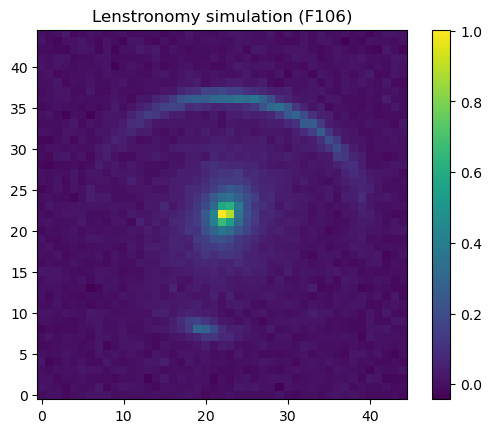

In [20]:
plt.imshow(image_f106, aspect='equal', origin='lower')
plt.title('Lenstronomy simulation (F106)')
plt.colorbar()
# plt.savefig('figures/roman.png')
plt.show()

In [ ]:
np.save('roman', image_f106)